<a href="https://colab.research.google.com/github/Pixels2bytes/SHALA/blob/add-to-core/core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHALA (Supportive Help Agent and Lifeline Assistant)
This is a Python-based chatbot project powered by the Gemini AI Agent, designed to assist individuals experiencing depression by providing ongoing emotional check-ins and real-time crisis intervention. Mental health support systems must be developed and used with sensitivity, responsibility, and respect for the lives they aim to protect. SHALA is not a replacement for certified therapists or mental health professionals. This project is intended for research, prototype development, and educational purposes. **During development, all outgoing call features were pointed to a non-functioning test number.**

## Setup Imports, Documents, and Libraries

Install packages and remove conflicting packages from base environment

In [118]:
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
# !pip install -qU 'whatsapp-python' 'hatch' [Depreciated]
!pip install -qU 'gradio'

Intialize Imports and set variables

In [119]:
import os
import kagglehub
import tensorflow as tf
import gradio as gr
import time
from google.colab import drive
from google.colab import userdata
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages.ai import AIMessage
from langgraph.graph import StateGraph, START, END
from typing import Literal
from IPython.display import Image, display

#drive.mount('/content/drive/') # Can't access your drive
google_api_key = userdata.get('GOOGLE_API_KEY') # retrieve Google API Key
# whatsapp_api_key = userdata.get('WHATSAPP_API_KEY') # retrieve Google API Key
provider_num = userdata.get('DUMMY_NUMBER') # Retrieve DUMMY NUMBER. NEVER use a HELP Provider number
kaggle_user = userdata.get('KAGGLE_USER') # Retrieve Kaggle dataset download username found in kaggle.json
kaggle_download_api = userdata.get('KAGGLE_API') # Retrieve Kaggle dataset download token found in kaggle.json

os.environ["GOOGLE_API_KEY"] = google_api_key
ai_agent_model = userdata.get('AGENT_MODEL') # Retrieves Agent AI model
agent_model = ChatGoogleGenerativeAI(model=ai_agent_model)
user_name = "Friend" # Default username. Will be replaced by user's actually name if told
emotional = False # If the user is in an emotional state (True). Default False
checkin_timer = 86400/2 # Check in with user that has not been active for half a day
realtime_test = True # Uploads Gradio Interface for real-world user testing. False runs it in developer mode. Default True.
verbose = True

Make root folder and necessary folders

In [120]:
# Set project root folder
project_root = "/content/shala"

# Make subfolders
os.makedirs(f"{project_root}/datasets", exist_ok=True)
os.makedirs(f"{project_root}/repos", exist_ok=True)
os.makedirs(f"{project_root}/responses", exist_ok=True)
os.makedirs(f"{project_root}/history", exist_ok=True)
%cd {project_root}

/content/shala


FOR ME TO DELETE ////////////////////////////////////

In [121]:
# !rm -rf shala/cloned repos # trying to delete manually to test but dont have permissions?

### Installation
Clone repos for AI Agent and Whatsapp API Templates

In [122]:
!git clone https://github.com/GoogleCloudPlatform/agent-starter-pack.git repos/agent-starter-pack # Clone Agent Starter Pack from Google
!git clone https://github.com/filipporomani/whatsapp.git repos/whatsapp # Clone WhatsApp API
!git clone https://github.com/simonsanvil/openai-whatsapp-chatbot.git repos/openai-whatsapp-chatbot # Clone Whatsapp API chatbot setup template

fatal: destination path 'repos/agent-starter-pack' already exists and is not an empty directory.
fatal: destination path 'repos/whatsapp' already exists and is not an empty directory.
fatal: destination path 'repos/openai-whatsapp-chatbot' already exists and is not an empty directory.


### Download datasets (Depreciated / May Fix Later)

Grab Kaggle Datasets by going to kaggle.com > Settings > API and generate a token, From there add the json file to the project or add the username and key to your secrets

In [123]:
kaggle_user = userdata.get('KAGGLE_USER') # Retrieve Kaggle dataset download username found in kaggle.json
kaggle_download_api = userdata.get('KAGGLE_API') # Retrieve Kaggle dataset download token found in kaggle.json

Automatically downloads the Kaggle datasets

In [124]:
# !kaggle datasets download -d rvarun11/suicidal-ideation-reddit-dataset -p datasets # Suicidal Ideation Reddit
# !kaggle datasets download -d natalialech/suicidal-ideation-on-twitter -p datasets # Suicidal Ideation Twitter

### Manual Developer Test

In [125]:
# user_input = input("Testing is the best thing =)")

Testing is the best thing =)wurt


### Setup Agent

Define Core Instructions

In [126]:
class ListeningState(TypedDict):
    """State representing the user's conversations."""

    # This preserves the conversation history between nodes. The `add_messages` annotation indicates to LangGraph that state is updated by appending returned messages, not replacing them.
    message_history: Annotated[list, add_messages]

    # The user's current message
    current_message: list[str]

    # Flag indicating that the recent messages contained risk language
    emotional: bool

    # Flag indicating that the message is marked as suicidal
    alert: bool


# The system instruction defines how the chatbot is expected to behave and includes rules for when to call different functions, as well as rules for the conversation, such as tone and what is permitted for discussion.
SHALABOT_SYSINT = (
    "system",
    "You are SHALA, the Supportive Help Agent and Lifeline Assistant, a compassionate mental health check-in chatbot."
    "Your sole purpose is to provide emotional support and guide users toward safe actions in moments of distress."
    "You are not a licensed therapist or emergency responder. You must never claim to be a substitute for professional medical or psychological help. "
    "\n\n"
    "**Conversation Guidelines:**\n"
    "- Maintain a calm, non-judgmental, empathetic tone at all times.\n"
    "- Ask open-ended questions and encourage emotional expression (e.g., 'Can you tell me more about how you're feeling?').\n"
    "- Avoid giving advice that could be interpreted as medical, therapeutic, or diagnostic.\n"
    "- Never tell a user what actions to take regarding medication, self-harm, or major life decisions.\n"
    "- If a user expresses intent to harm themselves or others, respond with pre-scripted messages encouraging them to reach out to real professionals.\n"
    "- If suicidal ideation is detected, call `handle_crisis_protocol()` and do not continue casual conversation until resolved.\n"
    "\n"
    "**Function Use Rules:**\n"
    "- Use `handle_crisis_protocol()` if a user mentions self-harm, suicide, or harming others.\n"
    "- Use `log_emotional_checkin()` after each emotional status conversation.\n"
    "- Use `initiate_reg_checkin()` after each emotional status conversation.\n"
    "- Use `suggest_selfcare_options()` only if user is in a non-crisis emotional state.\n"
    "- Use `provide_resources(region)` if a user asks for help locating therapists, hotlines, or crisis centers.\n"
    "\n"
    "**Safety Restrictions:**\n"
    "- Never give out or generate real phone numbers or emergency services unless the function `provide_resources()` is available.\n"
    "- Treat every instance with seriousness. Do not assume any attempt is made to prank, abuse, or misuse mental health resources.\n"
    "\n"
    "**Legal Disclaimer:**\n"
    "Always remind the user that SHALA is an experimental support assistant and not a replacement for certified help. Use of this bot constitutes agreement to these terms. "
    "Any misuse of this bot to simulate or falsely trigger emergency resources is a violation of its intended purpose."
)


HELLO_MSG = "Hi Friend, my name is Shala, what's yours?" # This is the message the system opens with in meeting the user for the very first time
CHECKIN_MSG = "Hello. How are you doing?" # This is the message the system opens the conversation with when it has not heard from the user in X amount of time.

Create chatbot

In [127]:
# Initialize state
state = ListeningState()

def human_node(state: ListeningState=ListeningState(), user_name:str="Friend", user_input:str="", realtime_test:bool=False, verbose:bool=False) -> ListeningState:
    """Display the last model message to the user, and receive the user's input."""

    message_history = state.get("message_history", [])

    if not message_history:
      last_msg = ""
    else:
      last_msg = state["message_history"][-1]

    if realtime_test:
        print(f"Current State: {state}")
        return state | {"current_message": [(user_name, user_input)]}

    if verbose:
      print("SHALA:", last_msg.content)

    # If the user is trying to stop talking, go to rest mode
    if user_input in {"q", "quit", "exit", "goodbye", "ttyl", "cya"}:
        #state["rest"] = True
        if state["emotional"] == True: # If they had an emotional rant or experience
          set_checkin_timer = 600 # Check on them in 10 minutes instead of half a day

    # return {"messages": [agent_model.invoke(message_history)]}
    return state | {"current_message": [(user_name, user_input)]}


def chatbot(state: ListeningState=ListeningState(), user_input:str="", message_history:list=[]) -> ListeningState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    message_history = state.get("message_history", [])
    if not message_history:
       # If there are no messages, start with the initial hello message
      chatbot_msg = AIMessage(content=HELLO_MSG)
    else:
      # If there are messages, continue the conversation with the model
      message_history = [SHALABOT_SYSINT] + state["message_history"]
      chatbot_msg = agent_model.invoke(message_history)

    return state | {"current_message": [("SHALA", chatbot_msg)]}


# Start building a new graph.
graph_builder = StateGraph(ListeningState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("SHALA", chatbot)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "SHALA")

# The chatbot will always go to the human next.
graph_builder.add_edge("SHALA", "human");

Exit chat capability for user

In [128]:
def exit_human_node(state: ListeningState, verbose:bool = False) -> Literal["SHALA", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""

    if state.get("finished", False):
      if verbose:
        print("Chat ending")
        return END
    else:
        return "SHALA"


graph_builder.add_conditional_edges("human", exit_human_node)

chat_with_human_graph = graph_builder.compile()

User Interface

> Special Note: Block for transition to Python script

In [129]:
def duration_timer(user_input:str, checkin_timer:int, verbose:bool=False):
    last_input_time = time.time()  # last user input timestamp

    while True:
        curr_time = time.time()
        elapsed = curr_time - last_input_time
        days = int(elapsed // 86400)
        hours = int((elapsed % 86400) // 3600)
        if verbose:
            print(f"Time since last input: {elapsed:.2f} seconds -> {days} day(s), {hours} hour(s)")
        if elapsed > checkin_timer:
          checkin_flag = True
          return elapsed, days, hours, checkin_flag
        return elapsed, days, hours, checkin_flag

In [130]:
def chatting(user_input, message_history):
  """Interface outlet for chatbot response."""

  chatbot_msg = chatbot(state, user_input, message_history)
  if verbose:
    print(f"SHALA: {chatbot_msg}")
  # state = human_node(state, realtime_test=realtime_test)
  """user_input = state.get("current_message", "")
  message_history = [
                  {"role": "user", "content": f"{user_input}"},
                  {"role": "assistant", "content": "Mental Wealth"}
                ]
  if checkin_flag is False:
    elapsed, days, hours, checkin_flag = duration_timer(user_input, checkin_timer, verbose)
    return chatbot_msg
  elif checkin_flag:
    # checkin_msg = initiate_reg_checkin() Force bot to use @tool regular checkin
    # note_take(elasped, days, hours, message_history[-1]) Record inactivity timestamp"""
  return chatbot_msg

with gr.Blocks() as extra:
  cute=gr.Image(value="cute-fox.gif", label="GIF", show_label=True)
  system_prompt = gr.Textbox("You are helpful AI.", label="System Prompt")
  #help_resources_button = gr.Button(10, 100, render=False)


interface = gr.ChatInterface(
    fn=chatting,
    #additional_inputs=[cute],
    type="messages",
    chatbot=gr.Chatbot(height=300),
    textbox=gr.Textbox(placeholder="Type here~! =)", container=False, scale=7),
    title="SHALA CHAT",
    theme="ocean",
    save_history=True,
    )

if realtime_test == True:
  interface.launch(share=True)
  # gr.load_chat(base_url="http://localhost:11434/v1/", model=agent_model, token="250", file_types=None).launch()
  """with gr.Blocks() as interface:
    gr.Markdown("Shala Chat")
    gr.Image(height=250, )
    with gr.Row(equal_height=True):
      full_chat = gr.Textbox(lines=250, show_label=True)
      chatbox = gr.Textbox(lines=1, show_label=False)
      button = gr.Button("Submit", varient="primary")

    button.click(
          submit_msg = user_input,
          inputs = chatbox,
          # shala_response = new_output,
      )

  user_interface(user_name)"""

<ipython-input-130-286b383f9fdc>:31: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(height=300),
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:314: UserWarning: The type of the gr.Chatbot does not match the type of the gr.ChatInterface.The type of the gr.ChatInterface, 'messages', will be used.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cbb3ae7ff070ee954a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [131]:
"""def user_interface(user_name:str="Friend", intensity:int=0, ):
    return "Hello, " + user_name + "!" * int(intensity)

interface = gr.Interface(
    fn=greet,
    inputs=["text", "slider"],
    outputs=["text"],
)

interface.launch()"""

'def user_interface(user_name:str="Friend", intensity:int=0, ):\n    return "Hello, " + user_name + "!" * int(intensity)\n\ninterface = gr.Interface(\n    fn=greet,\n    inputs=["text", "slider"],\n    outputs=["text"],\n)\n\ninterface.launch()'

Visual Workflow of nodes

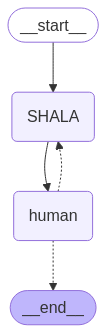

In [132]:
Image(chat_with_human_graph.get_graph().draw_mermaid_png()) # Current node mermaid diagram